<h3>Interpolating healpix maps</h3>

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors

from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.coordinates import Galactic
from astropy_healpix import HEALPix
from astropy import units as u
from astropy import wcs

import datetime

plt.style.use('thomas')

In [2]:
plt.style.use('thomas')

<h3>path to data</h3>

In [3]:
path = '/Users/thomassiegert/python/testing/PBH/ics_template/'

<h3>read in data</h3>

In [4]:
# Loading healpix, Ekin_min = 30 keV
healpix_Ek30 = fits.open(path+"ics_isotropic_healpix_54_0a050016")
healpix_Ek10 = fits.open(path+"ics_isotropic_healpix_54_0a050010")

In [5]:
healpix_Ek30.info()

Filename: /Users/thomassiegert/python/testing/PBH/ics_template/ics_isotropic_healpix_54_0a050016
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SKYMAP        1 BinTableHDU     20   196608R x 1C   [31D]   
  2  ENERGIES      1 BinTableHDU     12   31R x 1C   [1D]   


In [6]:
healpix_Ek30['SKYMAP'].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                  248 / width of table in bytes                        
NAXIS2  =               196608 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    1 / number of fields in each row                   
TTYPE1  = 'Spectra '           / label for field   1                            
TFORM1  = '31D     '           / data format of field: 8-byte DOUBLE            
TUNIT1  = 'Intensity'          / physical unit of field                         
EXTNAME = 'SKYMAP  '           / name of this binary table extension            
PIXTYPE = 'HEALPIX '        

<h3>find healpix representation</h3>

In [7]:
nside = healpix_Ek30['SKYMAP'].header['NSIDE']  
order = healpix_Ek30['SKYMAP'].header['ORDERING']  
hp = HEALPix(nside=nside, order=order, frame=Galactic()) 

<h3>define galactic coordinate grid<br>
    (NB: SPI's field of view is not restricted to the pointing selection (here: $|l| \le 40^{\circ}$, $|b| \le 40^{\circ}$), but has to take into account at least $8^{\circ}$ (fully coded) or $15^{\circ}$ (partially coded) in all directions to cover the edges of the field of view)</h3>

In [8]:
# definition of image space
poin_l_max = 40   #180-15
poin_l_min = -40  #-180+15
poin_b_max = 40   #90-15
poin_b_min = -40  #-90+15

# partially coded field of view
pcfov = 15

# minmax range
lmin,lmax = (poin_l_min-pcfov)*u.deg,(poin_l_max+pcfov)*u.deg
bmin,bmax = (poin_b_min-pcfov)*u.deg,(poin_b_max+pcfov)*u.deg
deg2rad = (np.pi/180)*u.rad

# SPI resolution is ~2.5 deg, here we oversample the resolution
binsize = 0.5*u.deg
n_l = int((lmax-lmin)/binsize)
n_b = int((bmax-bmin)/binsize)

# define lon, lat arrays, with and without boundaries
bg = np.linspace(bmin,bmax,n_b+1)
lg = np.linspace(lmin,lmax,n_l+1)
b = (bg[1:]+bg[0:-1])/2
l = (lg[1:]+lg[0:-1])/2

# define 2D meshgrid for image coordinates
L_ARRg, B_ARRg = np.meshgrid(lg,bg)
L_ARR, B_ARR = np.meshgrid(l,b)

# define solid angle for each pixel for normalisations later
domega = (binsize)*(np.sin(np.deg2rad(B_ARR+binsize/2)) - np.sin(np.deg2rad(B_ARR-binsize/2)))*u.rad
domega = domega.to('sr')

<h3>check covered solid angle of sky (for full sky should be $4\pi$)</h3>

In [9]:
np.sum(domega)

<Quantity 3.14531805 sr>

<h3>number of energy bins</h3>

In [10]:
n_e = len(healpix_Ek30['ENERGIES'].data['MeV'])

<h3>set up astropy coordinate object</h3>

In [11]:
coords = SkyCoord(L_ARR.ravel(), B_ARR.ravel(), frame=Galactic())

<h3>interpolate values for first map</h3>

In [12]:
# energy bin number 0
eb = 0

energy = (healpix_Ek30['ENERGIES'].data['MeV'][eb]*u.MeV).to('keV')

fluxes30 = healpix_Ek30['SKYMAP'].data['Spectra'][:,eb]
flux_map30 = hp.interpolate_bilinear_skycoord(coords, fluxes30)
flux_map30 = flux_map30.reshape((n_b, n_l))

fluxes10 = healpix_Ek10['SKYMAP'].data['Spectra'][:,eb]
flux_map10 = hp.interpolate_bilinear_skycoord(coords, fluxes10)
flux_map10 = flux_map10.reshape((n_b, n_l))

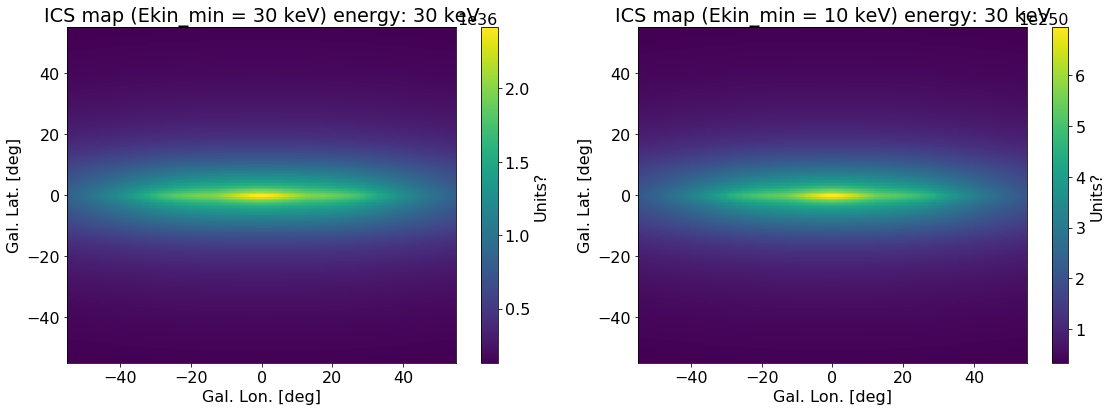

In [13]:
plt.figure(figsize=(16,6))

plt.subplot(121)
plt.pcolormesh(L_ARRg,B_ARRg,flux_map30)
plt.xlabel('Gal. Lon. [deg]')
plt.ylabel('Gal. Lat. [deg]')
plt.title(r'ICS map (Ekin_min = 30 keV) energy: {0:1.0f}'.format(energy))
plt.colorbar(label='Units?')

plt.subplot(122)
plt.pcolormesh(L_ARRg,B_ARRg,flux_map10)
plt.xlabel('Gal. Lon. [deg]')
plt.ylabel('Gal. Lat. [deg]')
plt.title(r'ICS map (Ekin_min = 10 keV) energy: {0:1.0f}'.format(energy))
plt.colorbar(label='Units?')

plt.tight_layout()

<h3>difference between maps?</h3>

In [14]:
flux_norm = 1e-4
flux_map30 = flux_map30*flux_norm/np.sum(flux_map30*domega.value)
flux_map10 = flux_map10*flux_norm/np.sum(flux_map10*domega.value)

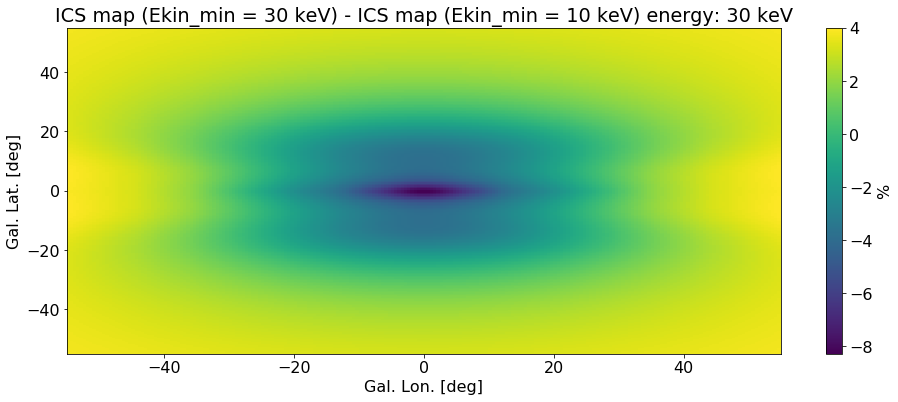

In [15]:
plt.figure(figsize=(16,6))

plt.pcolormesh(L_ARRg,B_ARRg,(flux_map30-flux_map10)/flux_map10*100)
plt.xlabel('Gal. Lon. [deg]')
plt.ylabel('Gal. Lat. [deg]')
plt.title(r'ICS map (Ekin_min = 30 keV) - ICS map (Ekin_min = 10 keV) energy: {0:1.0f}'.format(energy))
plt.colorbar(label='%')

<h3>looping and plotting all 31 maps</h3>

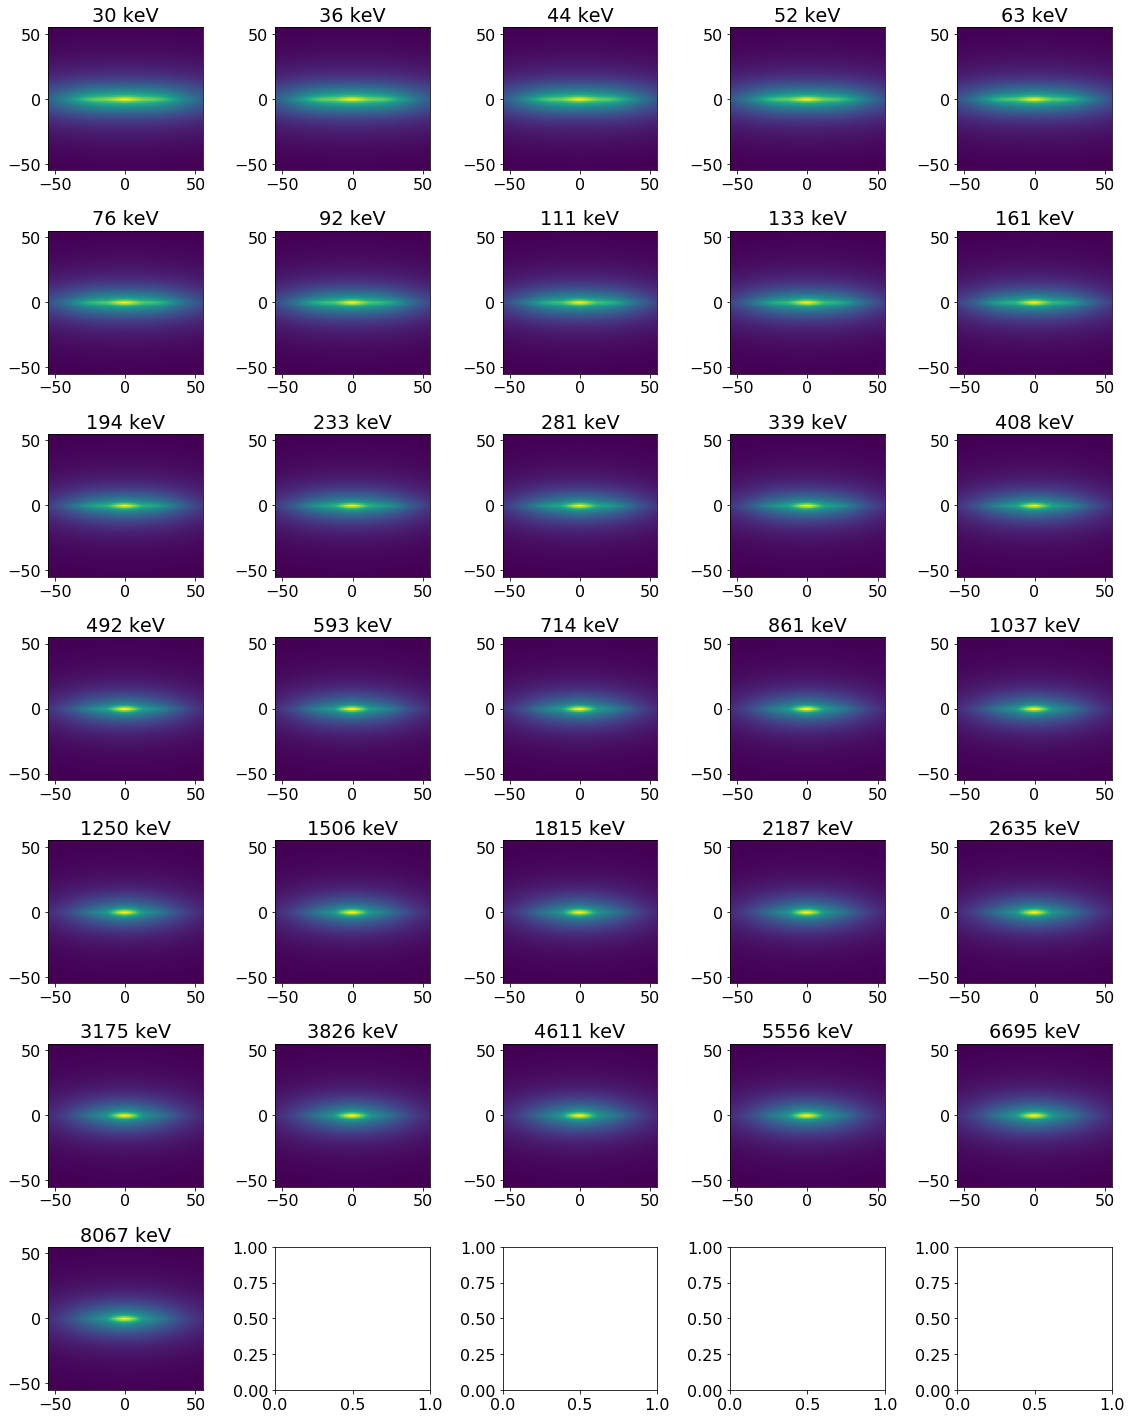

In [16]:
fig, ax = plt.subplots(ncols=5,nrows=7,figsize=(16,20))

cnt = 0
for eb in range(n_e):
    
    energy = (healpix_Ek30['ENERGIES'].data['MeV'][eb]*u.MeV).to('keV')

    fluxes = healpix_Ek30['SKYMAP'].data['Spectra'][:,eb]
    flux_map = hp.interpolate_bilinear_skycoord(coords, fluxes)
    flux_map = flux_map.reshape((n_b, n_l))
    
    (ax.ravel())[cnt].pcolormesh(L_ARRg,B_ARRg,flux_map)
    #(ax.ravel())[cnt].set_xlabel('Gal. Lon. [deg]')
    #(ax.ravel())[cnt].set_ylabel('Gal. Lat. [deg]')
    (ax.ravel())[cnt].set_title('{0:1.0f}'.format(energy))
    #(ax.ravel())[cnt].colorbar(label='Units?')
    
    cnt += 1
    
plt.tight_layout()

<h3>saving as rectangular maps in fits with normalisation to $10^{-4}\,\mathrm{ph\,cm^{-2}\,s^{-1}}$ total flux in each map (will be fitted anyway)</h3>

In [17]:
flux_norm = 1e-4

In [18]:
flux_map = flux_map*flux_norm/np.sum(flux_map*domega.value)
np.sum(flux_map*domega.value)

0.0001

<h3>setting up fits file information</h3>

In [19]:
wcs = wcs.WCS(naxis=2)
nx = np.copy(n_l)
ny = np.copy(n_b)
pixscalelon = binsize.value # cdelt1
pixscalelat = binsize.value  # cdelt2

wcs.wcs.crpix = [int(n_l/2)+1, int(n_b/2)+1] # Ref pixel for axis 1 and 2
wcs.wcs.cdelt = np.array([pixscalelon, pixscalelat]) # what is the pixel scale in lon, lat.
wcs.wcs.crval = [0.25,0.25] #what is the galactic coordinate of that pixel.
wcs.wcs.ctype = ["GLON-CAR", "GLAT-CAR"] #CAR projection #AIT projection

<h3>loop over energies and save files</h3>

In [20]:
for eb in range(n_e):
    
    # get map
    energy = (healpix_Ek30['ENERGIES'].data['MeV'][eb]*u.MeV).to('keV')

    fluxes = healpix_Ek30['SKYMAP'].data['Spectra'][:,eb]
    flux_map = hp.interpolate_bilinear_skycoord(coords, fluxes)
    flux_map = flux_map.reshape((n_b, n_l))
    
    # normalise to 1e-4
    save_flux_map = flux_map/np.sum(flux_map*domega.value)*flux_norm
    
    # write wcs to fits header
    now = datetime.date.today()
    header = wcs.to_header()
    header['HISTORY'] = 'Thomas Siegert [tsiegert@ucsd.edu] created this file on '+str(now)+' ' 
    header['COMMENT'] = 'ICS map created by Joanna Berteaud in healpix, converted to SPI readible format'
    header['COMMENT'] = 'Energy bin {0:1.0f}'.format(energy)

    # define header
    hdu = fits.PrimaryHDU(save_flux_map,header=header)
    
    # save file
    hdu.writeto(path+'ICS_SPI_ebin{0:02.0f}_Energy{1:04.0f}keV.fits'.format(eb,energy.value), overwrite=True)

In [21]:
# energy bin number 15 (near 511 keV)
eb = 15

energy = (healpix_Ek30['ENERGIES'].data['MeV'][eb]*u.MeV).to('keV')

fluxes = healpix_Ek30['SKYMAP'].data['Spectra'][:,eb]
flux_map = hp.interpolate_bilinear_skycoord(coords, fluxes)
flux_map = flux_map.reshape((n_b, n_l))
# normalise to 1e-4
flux_map = flux_map/np.sum(flux_map*domega.value)*flux_norm

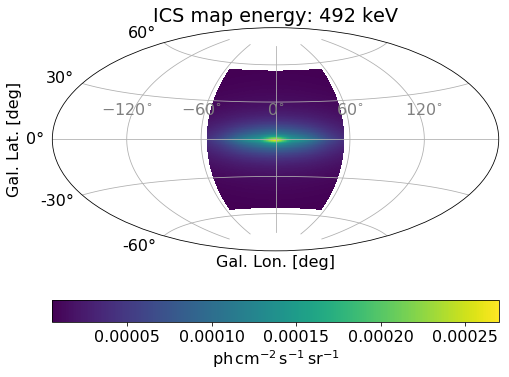

In [22]:
plt.subplot(projection='aitoff')
plt.pcolormesh(L_ARRg.to('rad'),B_ARRg.to('rad'),flux_map)
plt.xlabel('Gal. Lon. [deg]')
plt.ylabel('Gal. Lat. [deg]')
plt.title('ICS map energy: {0:1.0f}'.format(energy))
plt.colorbar(orientation='horizontal',label=r'$\mathrm{ph\,cm^{-2}\,s^{-1}\,sr^{-1}}$')

plt.xticks(np.array([-120,-60,0,60,120])*deg2rad.value,labels=[r'$-120^{\circ}$'+'\n',
                                                         r'$-60^{\circ}$'+'\n',
                                                         r'$0^{\circ}$'+'\n',
                                                         r'$60^{\circ}$'+'\n',
                                                         r'$120^{\circ}$'+'\n'],color='gray')
plt.yticks(np.array([-60,-30,0,30,60])*deg2rad.value)

plt.xlabel('Gal. Lon. [deg]')
plt.ylabel('Gal. Lat. [deg]')
plt.grid()